# Premier modèle de détection de formes 

Dans ce notebook, nous allons implémenter et entraîner un modèle de détection des formes. C'esr le modèle 3. Nous allons repartir du fichier train_with_bbox.csv (qui contient les définitions exactes des bounding boxes pour chaque couple image/forme).

### Schéma de prédiction

Afin de prédire les types de forme et leur localisation sur des images, nous pourrons par la suite construire un modèle hybride, qui combinera prédiction des classes (avec le modèle 2) puis prédiction des bounding boxes associées avec le modèle 3.
A noter que nous allons entraîner un modèle par pour chaque forme, afin d'avoir une prédiction plus fine.

## I. Préparation des données

Chargeons les packages requis et le fichier.

In [1]:
#Importation des packages nécessaires
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils
import tensorflow as tf
import os
import pandas as pd

import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D, BatchNormalization, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras import applications
from keras import optimizers
from keras.applications import VGG19
from keras.models import Model
from sklearn import metrics
import itertools
from keras import layers

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras import backend
from tensorflow.keras import callbacks
from tensorflow.keras import initializers

from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

In [2]:
img_size = 500
import pandas as pd
df = pd.read_csv('train_with_bbox_finalversion.csv')
df.head()

,Unnamed: 0,ImageId,Label,xmin,ymin,xmax,ymax
0,0,0011165.jpg,Fish,189,318,1183,1255
1,1,0011165.jpg,Flower,968,314,2094,1367
2,2,002be4f.jpg,Fish,167,10,2086,891
3,3,002be4f.jpg,Flower,956,879,2097,1398
4,4,002be4f.jpg,Sugar,48,295,944,645


Nous allons refactorer les coordonnées afin de décrire notre bounding box par le centre de la boîte (X,Y) et w et h sa largeur et hauteur respectives, renormalisées.

In [3]:
df['X'] = 0.5 * (df['xmin'] + df['xmax'])
df['Y'] = 0.5 * (df['ymin'] + df['ymax'])
df['w'] = (df['xmax'] - df['xmin'])
df['h'] = (df['ymax'] - df['ymin'])
# renormalisation
h_factor = 1/1400
w_factor = 1/2100
df['X'] = w_factor* df['X']
df['Y'] = h_factor* df['Y']
df['w'] = w_factor* df['w']
df['h'] = h_factor* df['h']
# suppression des colonnes inutiles
df = df.drop(['xmin','xmax', 'ymin','ymax'], axis = 1)
df = df.drop(['Unnamed: 0'], axis = 1)

In [4]:
df.head()

,ImageId,Label,X,Y,w,h
0,0011165.jpg,Fish,0.326667,0.561786,0.473333,0.669286
1,0011165.jpg,Flower,0.729048,0.600357,0.536190,0.752143
2,002be4f.jpg,Fish,0.536429,0.321786,0.913810,0.629286
3,002be4f.jpg,Flower,0.726905,0.813214,0.543333,0.370714
4,002be4f.jpg,Sugar,0.236190,0.335714,0.426667,0.250000


## II. Modèle de détection des bounding box - classe Fish

### II.A Chargement des données et séparation données entraînement/validation 

Nous allons commencer par nous intéresser à la forme 'Fish'. L'idée est donc de se limiter aux images contenant la forme Fish, et d'entraîner un modèle pour calculer la position et les dimensions de la bounding box associée.
La première étape consiste à filtrer les images qui nous intéressent (donc uniquement celles contenant la forme fish)

In [5]:
df_fish = df[df['Label'] == 'Fish']
df_fish.shape

(2777, 6)

Les images ayant déjà été créées, nous allons simplement les charger.

In [6]:
def modify_path(img):
    path = 'train_images_500/' + str(img)
    return path
df_fish['path'] = df_fish.ImageId.map(modify_path)
df_fish.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ImageId,Label,X,Y,w,h,path
0,0011165.jpg,Fish,0.326667,0.561786,0.473333,0.669286,train_images_500/0011165.jpg
2,002be4f.jpg,Fish,0.536429,0.321786,0.913810,0.629286,train_images_500/002be4f.jpg
5,0031ae9.jpg,Fish,0.433571,0.753571,0.865238,0.492857,train_images_500/0031ae9.jpg
10,003994e.jpg,Fish,0.901667,0.301429,0.192857,0.345714,train_images_500/003994e.jpg
14,006bf7c.jpg,Fish,0.342619,0.341786,0.655714,0.377857,train_images_500/006bf7c.jpg


In [7]:
from sklearn.model_selection import train_test_split
df_fish_train, df_fish_test = train_test_split(df_fish, test_size = 0.2)

In [8]:
from tqdm import tqdm

def load_data_regression(data):
    img_list=[]
    label_list=[]
    for i, f in enumerate(tqdm(data.values)):
        img = cv2.imread(f[6])
        img = cv2.resize(img, (300,300))#-channel_avr)/channel_std
        img_list.append(img) 
        X = f[2]
        Y = f[3]
        w = f[4]
        h = f[5]
        label_list.append([X,Y,w,h])
    print(img.shape)
    return np.array(img_list), np.array(label_list)

X_train, Y_train = load_data_regression(df_fish_train)
X_test, Y_test = load_data_regression(df_fish_test)

100%|██████████| 2221/2221 [00:26<00:00, 84.42it/s]


(300, 300, 3)


100%|██████████| 556/556 [00:06<00:00, 86.50it/s]


(300, 300, 3)


### II.B Définition du modèle

Ensuite nous repartons d'une architecture de type VGG19 pour construire notre modèle.
Nous chargeons le modèle utilisé pour les prédictions. Il sera nécessaire de le recharger et re-compiler pour chaque forme.

In [9]:
from keras import backend as K 
# Clear the old session.
K.clear_session()

pretrained_model = VGG19(input_shape=(300,300,3), include_top=False, weights="imagenet")
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for layer in pretrained_model.layers[15:]:
    layer.trainable = True
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
x = layers.Dense(4)(x)
model = Model(pretrained_model.input, x)

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

### II.B Définition de la fonction loss

Nous allons définir les fonctions de loss, nous en avons tester plusieurs. Celle retenue sera la MSE.

In [11]:
coef_w = 1
coef_x = 1
def loss_function(y_true, y_pred):
    return coef_x*K.square(y_true[:,0]-y_pred[:,0]) + K.square(y_true[:,1]-y_pred[:,1]) + coef_w*K.square(K.sqrt(K.abs(y_true[:,2])) - K.sqrt(K.abs(y_pred[:,2]))) + K.square(K.sqrt(K.abs(y_true[:,3])) - K.sqrt(K.abs(y_pred[:,3]))) + IOU(y_true,y_pred)
 


In [48]:
coef_w = 2
coef_h = 1
def MSE_function(y_true, y_pred):
    return K.square(y_true[:,0]-y_pred[:,0]) + K.square(y_true[:,1]-y_pred[:,1]) +coef_w*K.square(y_true[:,2]-y_pred[:,2]) + coef_h*K.square(y_true[:,3]-y_pred[:,3])
 

Nous avons également tenté de définir une fonction IOU, permettant de l'intégrer à notre calcul de loss, où de l'utiliser comme métrique pour analyser nos résultats.

In [13]:
def IOU(y_true, y_pred):
    # on recaclule min et max
    ymin_true = y_true[:,1]-y_true[:,3]/2
    ymax_true = y_true[:,1]+y_true[:,3]/2
    xmin_true = y_true[:,0]-y_true[:,2]/2
    xmax_true = y_true[:,0]+y_true[:,2]/2
    ymin_pred = y_pred[:,1]-y_pred[:,3]/2
    ymax_pred = y_pred[:,1]+y_pred[:,3]/2
    xmin_pred = y_pred[:,0]-y_pred[:,2]/2
    xmax_pred = y_pred[:,0]+y_pred[:,2]/2
    # coordonnées de la bbox intersection :
    xmin = tf.maximum(xmin_true, xmin_pred)
    ymin = tf.maximum(ymin_true, ymin_pred)
    xmax = tf.minimum(xmax_true, xmax_pred)
    ymax = tf.minimum(ymax_true, ymax_pred)
    # son aire :
    interArea = tf.maximum(0.0,xmax-xmin+1.0)*tf.maximum(0.0,ymax-ymin+1.0)
    # les aires des bbox d'entrée :
    trueArea = (xmax_true-xmin_true+1.0)*(ymax_true-ymin_true+1.0)
    predArea = (xmax_pred-xmin_pred+1.0)*(ymax_pred-ymin_pred+1.0)
    
    iou = interArea / (trueArea + predArea - interArea)
    return(tf.reduce_mean(iou))
#     return(iou)

In [14]:
def IOU_loss_function(y_true, y_pred) :
    return (-tf.math.log(iou(y_true, y_pred))+1.0)

Nous allons également définir les callbacks nécessaire pour l'entrainement du modèle

In [15]:
import os
cwd = os.getcwd()
filepath = cwd
from keras.optimizers import Adam
from tensorflow.keras import callbacks

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience=3,
                                         verbose=2,
                                         mode='min')
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 5,
                                         mode = 'min',
                                         restore_best_weights = True) 


checkpoint = callbacks.ModelCheckpoint(filepath = "weights_bboxfish.best.hdf5", 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

On compile le modèle, la fonction utilisé sera MSE_function

In [16]:
model.compile(optimizer=Adam(lr=0.001), loss=MSE_function, metrics=['accuracy'])

### II.C Entraînement du modèle

On lance l'entrainement du modèle pour la forme Fish.

In [24]:
n_epochs = 25
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), verbose=1, batch_size=100, epochs=n_epochs, callbacks = [lr_plateau, early_stopping, checkpoint])


Epoch 1/25
23/23 [==============================] - 346s 15s/step - accuracy: 0.2521 - loss: 100807.7031 - val_accuracy: 0.1673 - val_loss: 12.4707
Epoch 2/25
23/23 [==============================] - 346s 15s/step - accuracy: 0.2269 - loss: 8.8589 - val_accuracy: 0.2374 - val_loss: 1.3242
Epoch 3/25
23/23 [==============================] - 345s 15s/step - accuracy: 0.2413 - loss: 1.9316 - val_accuracy: 0.2518 - val_loss: 1.3976
Epoch 4/25
23/23 [==============================] - 351s 15s/step - accuracy: 0.2611 - loss: 0.9724 - val_accuracy: 0.2482 - val_loss: 0.8059
Epoch 5/25
23/23 [==============================] - 346s 15s/step - accuracy: 0.2706 - loss: 0.6541 - val_accuracy: 0.2482 - val_loss: 0.6661
Epoch 6/25
23/23 [==============================] - 346s 15s/step - accuracy: 0.2593 - loss: 0.5858 - val_accuracy: 0.2950 - val_loss: 0.6357
Epoch 7/25
23/23 [==============================] - 346s 15s/step - accuracy: 0.2823 - loss: 0.5429 - val_accuracy: 0.2194 - val_loss: 0.5648


Nous pouvons donc comparer les bounding boxes initiales et les bounding boxes prédites. Commençons par sauver le modèle.

In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model3_reg_Fish.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3_reg_Fish.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
Nous pouvons visualiser la convergence du modèle.

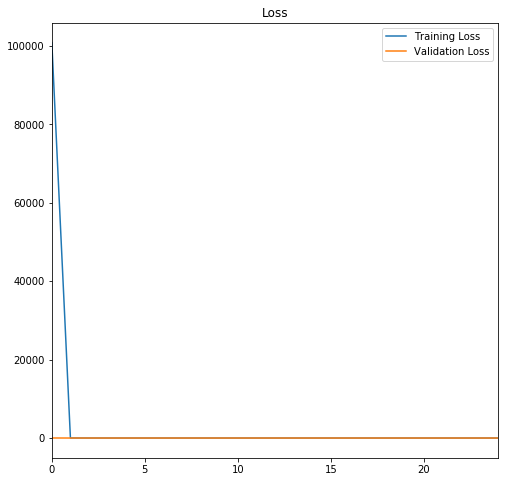

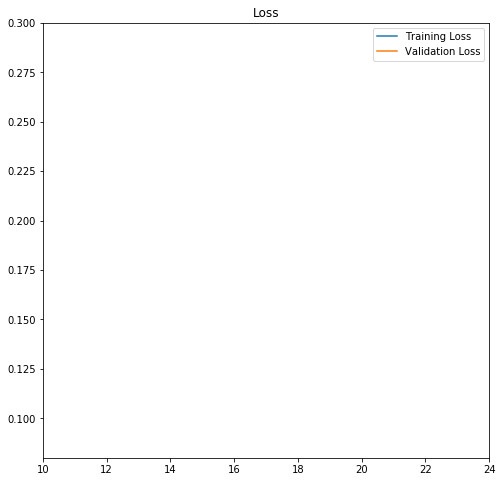

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

n_steps = 25
epochs_range = range(n_steps) # fonction pour récupérer le nbre d'epochs ?
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(0,n_steps-1)
plt.title('Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(10,n_steps-1)
plt.ylim(0.08,0.3)
plt.title('Loss')
plt.show()

### II.D Prédiction et analyse des bounding boxes "Fish" sur quelques images.

A partir de notre modèle, nous allons prédire les bounding boxes sur notre jeu de test (utilisé pour la validation dans l'entraînement). Nous rechargeons le modèle précédemment entraîné.

#### Chargement du modèle 3 (forme Fish)

In [51]:
K.clear_session()
with open("model3_reg_Fish.json", 'r') as json_file:
    json_savedModel= json_file.read()
# #load the model architecture 
    model_fish = tf.keras.models.model_from_json(json_savedModel)
    model_fish.load_weights('model3_reg_Fish.h5')
#model2.summary()

#### Comparaison des bounding boxes Fish sur une image du dataset

Nous définissons ici quelques fonctions qui nous seront utiles pour la visualisation.

In [16]:
def list_corners_IOU(y_true, y_pred) : #y_true = list(xmin, xmax, ymin, ymax)
    xmin = max(y_true[0], y_pred[0])
    ymin = max(y_true[2], y_pred[2])
    xmax = min(y_true[1], y_pred[1])
    ymax = min(y_true[3], y_pred[3])
    # son aire :
    interArea = max(0,xmax-xmin+1)*max(0,ymax-ymin+1)
    # les aires des bbox d'entrée :
    trueArea = (y_true[1]-y_true[0]+1)*(y_true[3]-y_true[2]+1)
    predArea = (y_pred[1]-y_pred[0]+1)*(y_pred[3]-y_pred[2]+1)
    
    return (interArea / (trueArea + predArea - interArea))
    

def show_img2(img,img_name,y_true, model,forme, factor):
    if forme == 0:
        typ_forme = 'Fish'
    if forme == 1:
        typ_forme = 'Flower'
    if forme == 2:
        typ_forme = 'Gravel'
    if forme == 3:
        typ_forme = 'Sugar'
    #xp0,yp0,wp0,hp0 = model.predict(np.array([img]))[0]
    img_r = cv2.resize(img, (factor,factor))
    img_d = cv2.resize(img, (2100,1400))
    plt.imshow(img_d[...,::-1])
    xt0,yt0,wt0,ht0 = [y_true[i] for i in range(len(y_true))]
    xt1= (xt0-wt0/2)*2100
    xt2= (xt0+wt0/2)*2100
    yt1= (yt0-ht0/2)*1400
    yt2= (yt0+ht0/2)*1400
    xp0,yp0,wp0,hp0 = model.predict(np.array([img_r]))[0]
    #print(xp0,yp0,wp0,hp0)
    xp1= max((xp0-abs(wp0)/2)*2100,0)
    xp2= min((xp0+abs(wp0)/2)*2100,2100)
    yp1= max((yp0-abs(hp0)/2)*1400,0)
    yp2= min((yp0+abs(hp0)/2)*1400,1400)
    plt.plot([xt1,xt2,xt2,xt1,xt1], [yt1,yt1,yt2,yt2,yt1], "r", label = 'True box')
    plt.plot([xp1,xp2,xp2,xp1,xp1], [yp1,yp1,yp2,yp2,yp1], "b", label = 'Predicted box')
    plt.legend(title= 'IOU = '+str(round(list_corners_IOU([xt1,xt2,yt1,yt2],[xp1,xp2,yp1,yp2]),2)))
    title = "Regression " + typ_forme + " - " + img_name
    plt.title(title)
    plt.show()

La visualisation d'une prédiction comparée au résultat attendu peut se faire à l'aide de la fonction suivante (pré-requis: avoir fait les étapes de préparation des données pour l'entraînement dans le notebook, il n'est en revanche pas nécessaire d'avoir entraîné le modèle puisque nous l'avons reloadé)

In [17]:
def show_prediction(df, model,typ_form):
    '''
    méthode prenant en argument
    - le dataframe construit lors du split de données avant l'entraînement
    - le model de regression correspondant
    _ le type de forme que l'on regresse (uniquement utile pour l'affichage ici)
    et qui affiche pour une image au hasard la boîte exacte et la boîte prédite
    '''
    k = np.random.randint(0, df.shape[0])
    img = cv2.imread(df.path.tolist()[k])
    img_name = df.iloc[k][0]
    y_true = df.iloc[k][2:6].tolist()
    show_img2(img,img_name,y_true, model,typ_form, 300)

#show_prediction(df_fish_train,model_fish, 0)

#### Analyse de la qualité de prédiction


Nous définissons la fonction qui va permettre de faire les prédiction des boudingbox à partir du modèle entrainé.

In [18]:
def get_prediction(path,model):
    img = cv2.imread(path)
    img_r = cv2.resize(img, (300,300))
    x,y,w,h = model.predict(np.array([img_r]))[0]
    return x,y,w,h

In [57]:
#attention temps de calcul long
df_test = df_fish.head(25)
df_test['pred'] = df_test['path'].apply(lambda x: get_prediction(x,model_fish))



/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [58]:
df_test.head()

,ImageId,Label,X,Y,w,h,path,pred
0,0011165.jpg,Fish,0.326667,0.561786,0.473333,0.669286,train_images_500/0011165.jpg,"(0.41244516, 0.42759922, 0.51035106, 0.42603797)"
2,002be4f.jpg,Fish,0.536429,0.321786,0.913810,0.629286,train_images_500/002be4f.jpg,"(0.5443726, 0.60027474, 0.49901366, 0.5165035)"
5,0031ae9.jpg,Fish,0.433571,0.753571,0.865238,0.492857,train_images_500/0031ae9.jpg,"(0.3229613, 0.46312943, 0.6367072, 0.4661197)"
10,003994e.jpg,Fish,0.901667,0.301429,0.192857,0.345714,train_images_500/003994e.jpg,"(0.38847467, 0.46493217, 0.4599682, 0.2756278)"
14,006bf7c.jpg,Fish,0.342619,0.341786,0.655714,0.377857,train_images_500/006bf7c.jpg,"(0.2976497, 0.45689234, 0.5012896, 0.39091462)"


In [59]:
df_test['X_p'] = df_test['pred'].apply(lambda x: x[0])
df_test['Y_p'] = df_test['pred'].apply(lambda x: x[1])
df_test['w_p'] = df_test['pred'].apply(lambda x: x[2])
df_test['h_p'] = df_test['pred'].apply(lambda x: x[3])
df_test['h_p'] = np.abs(df_test['h_p'])
df_test['w_p'] = np.abs(df_test['w_p'])
df_test.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,ImageId,Label,X,Y,w,h,path,pred,X_p,Y_p,w_p,h_p
0,0011165.jpg,Fish,0.326667,0.561786,0.473333,0.669286,train_images_500/0011165.jpg,"(0.41244516, 0.42759922, 0.51035106, 0.42603797)",0.412445,0.427599,0.510351,0.426038
2,002be4f.jpg,Fish,0.536429,0.321786,0.913810,0.629286,train_images_500/002be4f.jpg,"(0.5443726, 0.60027474, 0.49901366, 0.5165035)",0.544373,0.600275,0.499014,0.516504
5,0031ae9.jpg,Fish,0.433571,0.753571,0.865238,0.492857,train_images_500/0031ae9.jpg,"(0.3229613, 0.46312943, 0.6367072, 0.4661197)",0.322961,0.463129,0.636707,0.466120
10,003994e.jpg,Fish,0.901667,0.301429,0.192857,0.345714,train_images_500/003994e.jpg,"(0.38847467, 0.46493217, 0.4599682, 0.2756278)",0.388475,0.464932,0.459968,0.275628
14,006bf7c.jpg,Fish,0.342619,0.341786,0.655714,0.377857,train_images_500/006bf7c.jpg,"(0.2976497, 0.45689234, 0.5012896, 0.39091462)",0.297650,0.456892,0.501290,0.390915


In [101]:
df_test = df_test.drop(['pred'],axis = 1)
df_test.head()

,Unnamed: 0,ImageId,Label,X,Y,w,h,path,X_p,Y_p,w_p,h_p
0,0,0011165.jpg,Fish,0.326667,0.561786,0.473333,0.669286,train_images_500/0011165.jpg,0.412445,0.427599,0.510351,0.426038
1,2,002be4f.jpg,Fish,0.536429,0.321786,0.913810,0.629286,train_images_500/002be4f.jpg,0.544373,0.600275,0.499014,0.516504
2,5,0031ae9.jpg,Fish,0.433571,0.753571,0.865238,0.492857,train_images_500/0031ae9.jpg,0.322961,0.463129,0.636707,0.466120
3,10,003994e.jpg,Fish,0.901667,0.301429,0.192857,0.345714,train_images_500/003994e.jpg,0.388475,0.464932,0.459968,0.275628
4,14,006bf7c.jpg,Fish,0.342619,0.341786,0.655714,0.377857,train_images_500/006bf7c.jpg,0.297650,0.456892,0.501290,0.390915


Enfin nous pouvons sauvegarder le dataframe ainsi construit.

In [ ]:
#df_fish.to_csv('bbox_fishVGG19_MSE.csv')

#### Analyse des résultats (régression Fish)

Nous reloadons le dataframe construit à l'étape précédente.

In [60]:
df_fish = pd.read_csv('bbox_fishVGG19_MSE.csv')
df_fish.head()

,Unnamed: 0,ImageId,Label,X,Y,w,h,path,X_p,Y_p,w_p,h_p
0,0,0011165.jpg,Fish,0.326667,0.561786,0.473333,0.669286,train_images_500/0011165.jpg,0.412445,0.427599,0.510351,0.426038
1,2,002be4f.jpg,Fish,0.536429,0.321786,0.913810,0.629286,train_images_500/002be4f.jpg,0.544373,0.600275,0.499014,0.516504
2,5,0031ae9.jpg,Fish,0.433571,0.753571,0.865238,0.492857,train_images_500/0031ae9.jpg,0.322961,0.463129,0.636707,0.466120
3,10,003994e.jpg,Fish,0.901667,0.301429,0.192857,0.345714,train_images_500/003994e.jpg,0.388475,0.464932,0.459968,0.275628
4,14,006bf7c.jpg,Fish,0.342619,0.341786,0.655714,0.377857,train_images_500/006bf7c.jpg,0.297650,0.456892,0.501290,0.390915


Nous pouvons visualiser les distributions prédites et exactes de nos dimensions, ainsi que leurs nuages de point (une prédiction exacte consisterait en une droite).

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


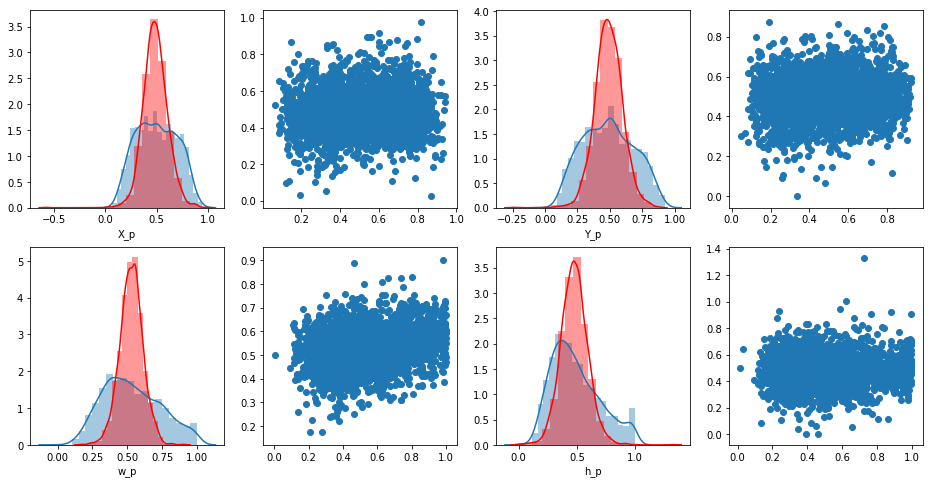

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

true = ['X','Y','w','h']
pred = ['X_p','Y_p','w_p','h_p']

plt.figure(figsize = (16,8))
for i in np.arange(0,8,2) :
    plt.subplot(2,4,i+1)
    sns.distplot(df_fish[true[(i+1)//2]], bins = 20)
    sns.distplot(df_fish[pred[(i+1)//2]], bins = 20, color = 'r')
    plt.subplot(2,4,i+2)
    plt.scatter(df_fish[true[i//2]],df_fish[pred[i//2]].map(lambda x : np.abs(x)))
    #     sns.relplot(x=true[i//2], y=pred[i//2], data = df_fish)
plt.show();

Nous pouvons également calculer l'IOU moyen correspondant.

In [75]:
np.mean(IOU(df_fish[['X','Y','w','h']].values ,df_fish[['X_p','Y_p','w_p','h_p']].values))#.numpy()
#print(IOU(df_fish[['X','Y','w','h']].values ,df_fish[['X_p','Y_p','w_p','h_p']].values))#.numpy())

0.6080780097501974

Nous effaçons les paramètres du modèle appris pour faire les entrainements des autres formes.

In [76]:
del X_train
del X_test
del Y_train
del Y_test

In [39]:
del model
K.clear_session()

## III. Modèle de détection des bounding box - classe Flower

Nous décrivons ici la même méthode que celle appliquée pour la forme Fish, mais cette fois ci pour la forme flower.

In [61]:
df_flower = df[df['Label'] == 'Flower']
df_flower.shape

(2360, 6)

Les images ayant été créées, nous allons simplement les charger.

In [62]:
def modify_path(img):
    path = 'train_images_500/' + str(img)
    return path

df_flower['path'] = df_flower.ImageId.map(modify_path)
df_flower.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ImageId,Label,X,Y,w,h,path
1,0011165.jpg,Flower,0.729048,0.600357,0.536190,0.752143,train_images_500/0011165.jpg
3,002be4f.jpg,Flower,0.726905,0.813214,0.543333,0.370714,train_images_500/002be4f.jpg
6,0031ae9.jpg,Flower,0.353810,0.661071,0.706667,0.606429,train_images_500/0031ae9.jpg
8,0035239.jpg,Flower,0.257143,0.266429,0.445714,0.515714,train_images_500/0035239.jpg
21,0091591.jpg,Flower,0.651667,0.613929,0.694762,0.772143,train_images_500/0091591.jpg


In [65]:
from sklearn.model_selection import train_test_split
df_flower_train, df_flower_test = train_test_split(df_flower, test_size = 0.2)

Il est nécessaire de recharger le modèle VGG19 + le compiler car le K.clear_session() a effacé le modèle compilé.
Re-executer les deux commandes : chargement du modèle + compilation du modèle ( plus haut dans le Notebook).

In [66]:
X_train, Y_train = load_data_regression(df_flower_train)
X_test, Y_test = load_data_regression(df_flower_test)

  0%|          | 0/472 [00:00<?, ?it/s]

(300, 300, 3)


100%|██████████| 472/472 [00:04<00:00, 100.02it/s]


(300, 300, 3)


In [23]:
n_epochs = 25
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), verbose=1, batch_size=100, epochs=n_epochs, callbacks = [lr_plateau, early_stopping, checkpoint])

Epoch 1/25
19/19 [==============================] - 299s 16s/step - accuracy: 0.2251 - loss: 108389.2344 - val_accuracy: 0.1843 - val_loss: 1731.8346
Epoch 2/25
19/19 [==============================] - 297s 16s/step - accuracy: 0.2341 - loss: 259.1894 - val_accuracy: 0.3072 - val_loss: 62.9461
Epoch 3/25
19/19 [==============================] - 298s 16s/step - accuracy: 0.2452 - loss: 18.6459 - val_accuracy: 0.2648 - val_loss: 5.4398
Epoch 4/25
19/19 [==============================] - 299s 16s/step - accuracy: 0.2315 - loss: 18.8242 - val_accuracy: 0.2267 - val_loss: 2.0947
Epoch 5/25
19/19 [==============================] - 295s 16s/step - accuracy: 0.2251 - loss: 32.9016 - val_accuracy: 0.2225 - val_loss: 3.6341
Epoch 6/25
19/19 [==============================] - 298s 16s/step - accuracy: 0.2728 - loss: 3.3721 - val_accuracy: 0.3136 - val_loss: 0.8100
Epoch 7/25
19/19 [==============================] - 300s 16s/step - accuracy: 0.2622 - loss: 0.6978 - val_accuracy: 0.2564 - val_loss:

In [24]:
# serialize model to JSON
model_json = model.to_json()
with open("modelREGRESSION_VGG19_Flower.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelREGRESSION_VGG19_Flower.h5")
print("Saved model to disk")

Saved model to disk


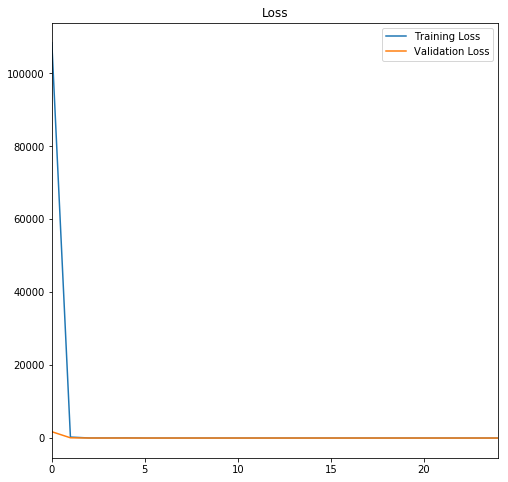

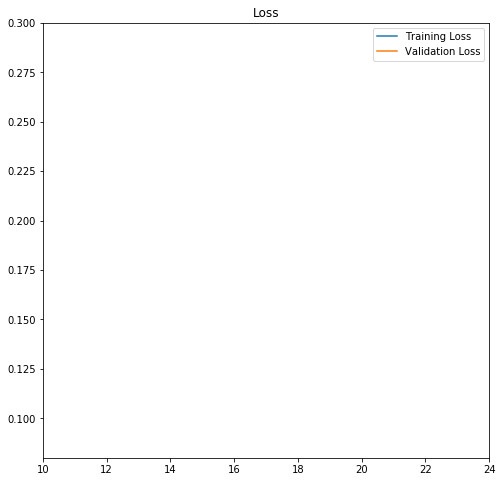

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

n_steps = 25
epochs_range = range(n_steps) # fonction pour récupérer le nbre d'epochs ?
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(0,n_steps-1)
plt.title('Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(10,n_steps-1)
plt.ylim(0.08,0.3)
plt.title('Loss')
plt.show()

### Prédiction et analyse des bounding boxes "Flower" sur quelques images.

#### Prédiction et sauvegarde des résultats


In [63]:
K.clear_session()
with open("model3_reg_Flower.json", 'r') as json_file:
    json_savedModel= json_file.read()
# #load the model architecture 
    model_flower = tf.keras.models.model_from_json(json_savedModel)
    model_flower.load_weights('model3_reg_Flower.h5')
#model2.summary()

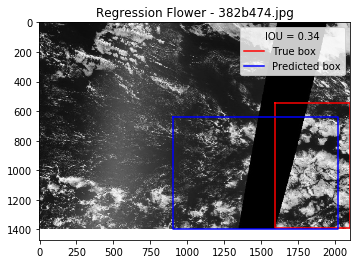

In [69]:
show_prediction(df_flower_train,model_flower, 1)

Les cellules suivantes permettent de créer et sauvegarder un csv avec les prédictions (temps long de calcul). Dans la partie analyse, il est possible de reloader directment le csv correspondant.

In [70]:
#ici nous remettons le code pour seulement une partie des images pour éviter un temps de calcul trop long

df_flower['pred'] = df_flower['path'].apply(lambda x: get_prediction(x,model_flower))

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [71]:
df_flower.head()

,ImageId,Label,X,Y,w,h,path,pred
1,0011165.jpg,Flower,0.729048,0.600357,0.536190,0.752143,train_images_500/0011165.jpg,"(0.67003566, 0.38297045, 0.67719465, 0.5577481)"
3,002be4f.jpg,Flower,0.726905,0.813214,0.543333,0.370714,train_images_500/002be4f.jpg,"(0.58086777, 0.5225116, 0.5247535, 0.53607607)"
6,0031ae9.jpg,Flower,0.353810,0.661071,0.706667,0.606429,train_images_500/0031ae9.jpg,"(0.5026027, 0.5395299, 0.5558248, 0.5450945)"
8,0035239.jpg,Flower,0.257143,0.266429,0.445714,0.515714,train_images_500/0035239.jpg,"(0.61775404, 0.73971236, 0.45102602, 0.6390817)"
21,0091591.jpg,Flower,0.651667,0.613929,0.694762,0.772143,train_images_500/0091591.jpg,"(0.44730508, 0.5248797, 0.52312535, 0.5872309)"


In [72]:
df_flower['X_p'] = df_flower['pred'].apply(lambda x: x[0])
df_flower['Y_p'] = df_flower['pred'].apply(lambda x: x[1])
df_flower['w_p'] = df_flower['pred'].apply(lambda x: x[2])
df_flower['h_p'] = df_flower['pred'].apply(lambda x: x[3])
df_flower['h_p'] = np.abs(df_flower['h_p'])
df_flower['w_p'] = np.abs(df_flower['w_p'])
df_flower.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,ImageId,Label,X,Y,w,h,path,pred,X_p,Y_p,w_p,h_p
1,0011165.jpg,Flower,0.729048,0.600357,0.536190,0.752143,train_images_500/0011165.jpg,"(0.67003566, 0.38297045, 0.67719465, 0.5577481)",0.670036,0.382970,0.677195,0.557748
3,002be4f.jpg,Flower,0.726905,0.813214,0.543333,0.370714,train_images_500/002be4f.jpg,"(0.58086777, 0.5225116, 0.5247535, 0.53607607)",0.580868,0.522512,0.524754,0.536076
6,0031ae9.jpg,Flower,0.353810,0.661071,0.706667,0.606429,train_images_500/0031ae9.jpg,"(0.5026027, 0.5395299, 0.5558248, 0.5450945)",0.502603,0.539530,0.555825,0.545094
8,0035239.jpg,Flower,0.257143,0.266429,0.445714,0.515714,train_images_500/0035239.jpg,"(0.61775404, 0.73971236, 0.45102602, 0.6390817)",0.617754,0.739712,0.451026,0.639082
21,0091591.jpg,Flower,0.651667,0.613929,0.694762,0.772143,train_images_500/0091591.jpg,"(0.44730508, 0.5248797, 0.52312535, 0.5872309)",0.447305,0.524880,0.523125,0.587231


In [73]:
df_flower = df_flower.drop(['pred'],axis = 1)
df_flower.head()

,ImageId,Label,X,Y,w,h,path,X_p,Y_p,w_p,h_p
1,0011165.jpg,Flower,0.729048,0.600357,0.536190,0.752143,train_images_500/0011165.jpg,0.670036,0.382970,0.677195,0.557748
3,002be4f.jpg,Flower,0.726905,0.813214,0.543333,0.370714,train_images_500/002be4f.jpg,0.580868,0.522512,0.524754,0.536076
6,0031ae9.jpg,Flower,0.353810,0.661071,0.706667,0.606429,train_images_500/0031ae9.jpg,0.502603,0.539530,0.555825,0.545094
8,0035239.jpg,Flower,0.257143,0.266429,0.445714,0.515714,train_images_500/0035239.jpg,0.617754,0.739712,0.451026,0.639082
21,0091591.jpg,Flower,0.651667,0.613929,0.694762,0.772143,train_images_500/0091591.jpg,0.447305,0.524880,0.523125,0.587231


In [74]:
df_flower.to_csv('bbox_flowerVGG19_MSE.csv')

#### Analyse des résultats (régression Flower)

In [75]:
df_flower = pd.read_csv('bbox_flowerVGG19_MSE.csv')
df_flower.head()

,Unnamed: 0,ImageId,Label,X,Y,w,h,path,X_p,Y_p,w_p,h_p
0,1,0011165.jpg,Flower,0.729048,0.600357,0.536190,0.752143,train_images_500/0011165.jpg,0.670036,0.382970,0.677195,0.557748
1,3,002be4f.jpg,Flower,0.726905,0.813214,0.543333,0.370714,train_images_500/002be4f.jpg,0.580868,0.522512,0.524754,0.536076
2,6,0031ae9.jpg,Flower,0.353810,0.661071,0.706667,0.606429,train_images_500/0031ae9.jpg,0.502603,0.539530,0.555825,0.545094
3,8,0035239.jpg,Flower,0.257143,0.266429,0.445714,0.515714,train_images_500/0035239.jpg,0.617754,0.739712,0.451026,0.639082
4,21,0091591.jpg,Flower,0.651667,0.613929,0.694762,0.772143,train_images_500/0091591.jpg,0.447305,0.524880,0.523125,0.587231


/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


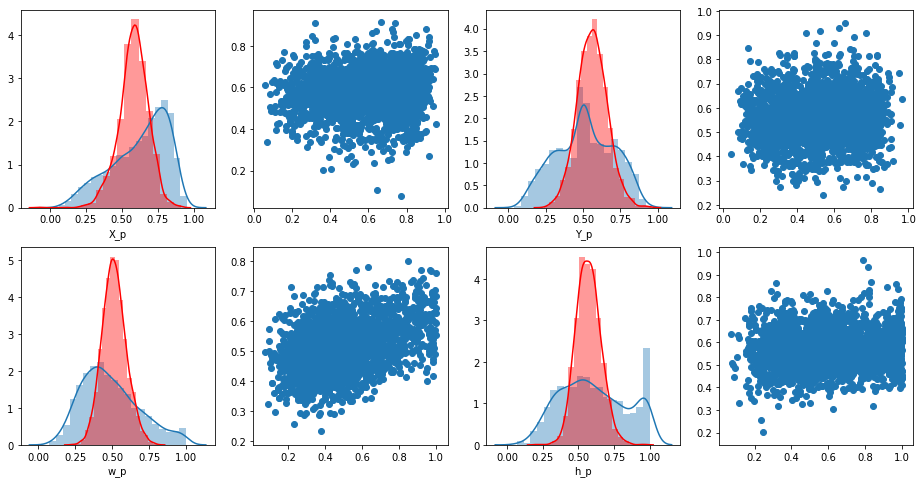

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

true = ['X','Y','w','h']
pred = ['X_p','Y_p','w_p','h_p']

plt.figure(figsize = (16,8))
for i in np.arange(0,8,2) :
    plt.subplot(2,4,i+1)
    sns.distplot(df_flower[true[(i+1)//2]], bins = 20)
    sns.distplot(df_flower[pred[(i+1)//2]], bins = 20, color = 'r')
    plt.subplot(2,4,i+2)
    plt.scatter(df_flower[true[i//2]],df_flower[pred[i//2]].map(lambda x : np.abs(x)))
    #     sns.relplot(x=true[i//2], y=pred[i//2], data = df_fish)
plt.show();

In [123]:
IOU(df_flower[['X','Y','w','h']].values ,df_flower[['X_p','Y_p','w_p','h_p']].values).numpy()

0.6156320057018038

Nous effaçons les paramètres du modèle appris pour faire les entrainements des autres formes.

In [50]:
del X_train
del X_test
del Y_train
del Y_test

In [51]:
del model
K.clear_session()

## IV. Modèle de détection des bounding box - classe Sugar


In [124]:
df_sugar = df[df['Label'] == 'Sugar']
df_sugar.shape

(3750, 6)

Les images ayant été créées, nous allons simplement les charger.

In [125]:
def modify_path(img):
    path = 'train_images_500/' + str(img)
    return path

df_sugar['path'] = df_sugar.ImageId.map(modify_path)
df_sugar.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ImageId,Label,X,Y,w,h,path
4,002be4f.jpg,Sugar,0.236190,0.335714,0.426667,0.250000,train_images_500/002be4f.jpg
7,0031ae9.jpg,Sugar,0.411905,0.260000,0.376190,0.277143,train_images_500/0031ae9.jpg
12,003994e.jpg,Sugar,0.114762,0.182500,0.210476,0.349286,train_images_500/003994e.jpg
15,006bf7c.jpg,Sugar,0.281429,0.081071,0.560000,0.132143,train_images_500/006bf7c.jpg
17,006c5a6.jpg,Sugar,0.512619,0.689286,0.970952,0.607143,train_images_500/006c5a6.jpg


In [126]:
from sklearn.model_selection import train_test_split
df_sugar_train, df_sugar_test = train_test_split(df_sugar, test_size = 0.2)

Il est nécessaire de recharger le modèle VGG19 + le compiler car le K.clear_session() a effacé le modèle compilé.
Re-executer les deux commandes : chargement du modèle + compilation du modèle ( plus haut dans le Notebook).

In [23]:
X_train, Y_train = load_data_regression(df_sugar_train)
X_test, Y_test = load_data_regression(df_sugar_test)

100%|██████████| 3000/3000 [00:34<00:00, 87.00it/s]


(300, 300, 3)


100%|██████████| 750/750 [00:08<00:00, 89.99it/s]


(300, 300, 3)


In [24]:
print(np.max(Y_train))
print(np.min(Y_train))
print(np.max(Y_test))
print(np.min(Y_test))

0.9995238095238095
0.05261904761904762
0.9976190476190476
0.06392857142857143


In [25]:
n_epochs = 25
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), verbose=1, batch_size=100, epochs=n_epochs, callbacks = [lr_plateau, early_stopping, checkpoint])

Epoch 1/25
30/30 [==============================] - 480s 16s/step - loss: 54612.7617 - accuracy: 0.2487 - val_loss: 342.4612 - val_accuracy: 0.1960
Epoch 2/25
30/30 [==============================] - 477s 16s/step - loss: 155.6075 - accuracy: 0.2580 - val_loss: 12.0087 - val_accuracy: 0.3200
Epoch 3/25
30/30 [==============================] - 488s 16s/step - loss: 5.9867 - accuracy: 0.2880 - val_loss: 2.8314 - val_accuracy: 0.2893
Epoch 4/25
30/30 [==============================] - 476s 16s/step - loss: 2.2681 - accuracy: 0.2667 - val_loss: 1.8187 - val_accuracy: 0.3040
Epoch 5/25
30/30 [==============================] - 476s 16s/step - loss: 1.4999 - accuracy: 0.2580 - val_loss: 1.2301 - val_accuracy: 0.2800
Epoch 6/25
30/30 [==============================] - 481s 16s/step - loss: 1.1088 - accuracy: 0.2653 - val_loss: 1.0148 - val_accuracy: 0.3213
Epoch 7/25
30/30 [==============================] - 476s 16s/step - loss: 0.8743 - accuracy: 0.2693 - val_loss: 0.7522 - val_accuracy: 0.31

Nous pouvons donc comparer les bounding boxes initiales et les bounding boxes prédites. Commençons par sauver le modèle.

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("model3_reg_Sugar.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3_reg_Sugar.h5")
print("Saved model to disk")

Saved model to disk


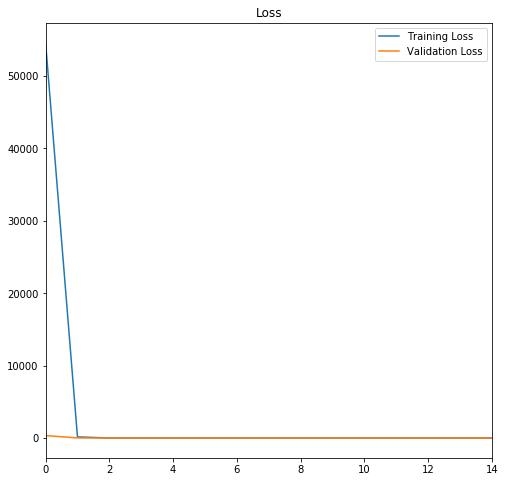

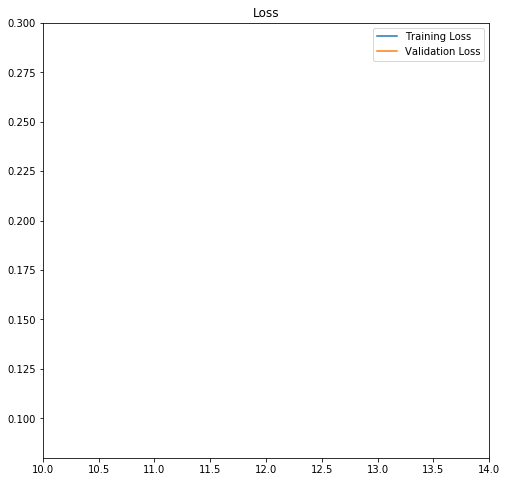

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

n_steps = 15
epochs_range = range(n_steps) # fonction pour récupérer le nbre d'epochs ?
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(0,n_steps-1)
plt.title('Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(10,n_steps-1)
plt.ylim(0.08,0.3)
plt.title('Loss')
plt.show()

### III.B Prédiction et analyse des bounding boxes "Sugar" sur quelques images.

A partir de notre modèle, nous allons prédire les bounding boxes sur notre jeu de test (utilisé pour la validation dans l'entraînement). 

In [127]:
K.clear_session()
with open("model3_reg_Sugar.json", 'r') as json_file:
    json_savedModel= json_file.read()
# #load the model architecture 
    model_sugar = tf.keras.models.model_from_json(json_savedModel)
    model_sugar.load_weights('model3_reg_Sugar.h5')
#model2.summary()

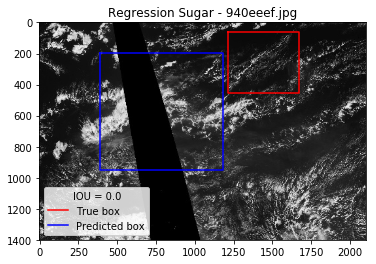

In [143]:

show_prediction(df_sugar_train,model_sugar, 3)

In [132]:
df_sugar = df_sugar.head(30)
df_sugar['pred'] = df_sugar['path'].apply(lambda x: get_prediction(x,model_sugar))

In [133]:
df_sugar['X_p'] = df_sugar['pred'].apply(lambda x: x[0])
df_sugar['Y_p'] = df_sugar['pred'].apply(lambda x: x[1])
df_sugar['w_p'] = df_sugar['pred'].apply(lambda x: x[2])
df_sugar['h_p'] = df_sugar['pred'].apply(lambda x: x[3])
df_sugar['h_p'] = np.abs(df_sugar['h_p'])
df_sugar['w_p'] = np.abs(df_sugar['w_p'])
df_sugar.head()

,ImageId,Label,X,Y,w,h,path,pred,X_p,Y_p,w_p,h_p
4,002be4f.jpg,Sugar,0.236190,0.335714,0.426667,0.250000,train_images_500/002be4f.jpg,"(0.19302084, 0.48992014, 0.5634714, 0.48438203)",0.193021,0.489920,0.563471,0.484382
7,0031ae9.jpg,Sugar,0.411905,0.260000,0.376190,0.277143,train_images_500/0031ae9.jpg,"(0.4130235, 0.55482125, 0.6094213, 0.4239272)",0.413024,0.554821,0.609421,0.423927
12,003994e.jpg,Sugar,0.114762,0.182500,0.210476,0.349286,train_images_500/003994e.jpg,"(0.24058391, 0.12935744, 0.3529509, 0.39709055)",0.240584,0.129357,0.352951,0.397091
15,006bf7c.jpg,Sugar,0.281429,0.081071,0.560000,0.132143,train_images_500/006bf7c.jpg,"(0.5049697, 0.38024402, 0.47218522, 0.516158)",0.504970,0.380244,0.472185,0.516158
17,006c5a6.jpg,Sugar,0.512619,0.689286,0.970952,0.607143,train_images_500/006c5a6.jpg,"(0.4139686, 0.28680682, 0.3169702, 0.4515096)",0.413969,0.286807,0.316970,0.451510


In [134]:
df_sugar = df_sugar.drop(['pred'],axis = 1)
df_sugar.head()

,ImageId,Label,X,Y,w,h,path,X_p,Y_p,w_p,h_p
4,002be4f.jpg,Sugar,0.236190,0.335714,0.426667,0.250000,train_images_500/002be4f.jpg,0.193021,0.489920,0.563471,0.484382
7,0031ae9.jpg,Sugar,0.411905,0.260000,0.376190,0.277143,train_images_500/0031ae9.jpg,0.413024,0.554821,0.609421,0.423927
12,003994e.jpg,Sugar,0.114762,0.182500,0.210476,0.349286,train_images_500/003994e.jpg,0.240584,0.129357,0.352951,0.397091
15,006bf7c.jpg,Sugar,0.281429,0.081071,0.560000,0.132143,train_images_500/006bf7c.jpg,0.504970,0.380244,0.472185,0.516158
17,006c5a6.jpg,Sugar,0.512619,0.689286,0.970952,0.607143,train_images_500/006c5a6.jpg,0.413969,0.286807,0.316970,0.451510


In [135]:
#df_sugar.to_csv('bbox_sugarVGG19_MSE.csv')
df_sugar = pd.read_csv('bbox_sugarVGG19_MSE.csv')

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


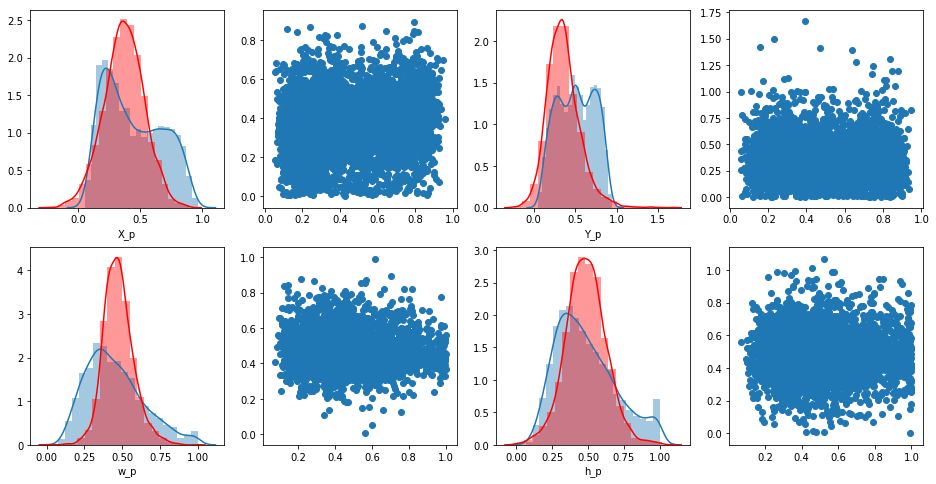

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

true = ['X','Y','w','h']
pred = ['X_p','Y_p','w_p','h_p']

plt.figure(figsize = (16,8))
for i in np.arange(0,8,2) :
    plt.subplot(2,4,i+1)
    sns.distplot(df_sugar[true[(i+1)//2]], bins = 20)
    sns.distplot(df_sugar[pred[(i+1)//2]], bins = 20, color = 'r')
    plt.subplot(2,4,i+2)
    plt.scatter(df_sugar[true[i//2]],df_sugar[pred[i//2]].map(lambda x : np.abs(x)))
    #     sns.relplot(x=true[i//2], y=pred[i//2], data = df_fish)
plt.show();

In [137]:
IOU(df_sugar[['X','Y','w','h']].values ,df_sugar[['X_p','Y_p','w_p','h_p']].values).numpy()

0.5143910502998649

Nous effaçons les paramètres du modèle appris pour faire les entrainements des autres formes.

In [36]:
del X_train
del X_test
del Y_train
del Y_test

In [37]:
del model
K.clear_session()

## V. Modèle de détection des bounding box - classe Gravel


In [51]:
df_gravel = df[df['Label'] == 'Gravel']
df_gravel.shape

(2935, 6)

Les images ayant été créées, nous allons simplement les charger.

In [52]:
def modify_path(img):
    path = 'train_images_500/' + str(img)
    return path

df_gravel['path'] = df_gravel.ImageId.map(modify_path)
df_gravel.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ImageId,Label,X,Y,w,h,path
9,0035239.jpg,Gravel,0.203333,0.850000,0.362857,0.271429,train_images_500/0035239.jpg
11,003994e.jpg,Gravel,0.354762,0.517857,0.469524,0.297143,train_images_500/003994e.jpg
13,00498ec.jpg,Gravel,0.169762,0.354286,0.117619,0.394286,train_images_500/00498ec.jpg
22,0091591.jpg,Gravel,0.344048,0.316071,0.679524,0.605000,train_images_500/0091591.jpg
26,009e2f3.jpg,Gravel,0.876190,0.624286,0.217143,0.731429,train_images_500/009e2f3.jpg


In [53]:
from sklearn.model_selection import train_test_split
df_gravel_train, df_gravel_test = train_test_split(df_gravel, test_size = 0.2)

Il est nécessaire de recharger le modèle VGG19 + le compiler car le K.clear_session() a effacé le modèle compilé.
Re-executer les deux commandes : chargement du modèle + compilation du modèle ( plus haut dans le Notebook).

In [54]:
X_train, Y_train = load_data_regression(df_gravel_train)
X_test, Y_test = load_data_regression(df_gravel_test)

100%|██████████| 2348/2348 [00:08<00:00, 280.56it/s]


(300, 300, 3)


100%|██████████| 587/587 [00:02<00:00, 286.80it/s]

(300, 300, 3)


In [55]:
from keras import backend as K 
# Clear the old session.
K.clear_session()

pretrained_model = VGG19(input_shape=(300,300,3), include_top=False, weights="imagenet")
for layer in pretrained_model.layers[:15]:
    layer.trainable = False
for layer in pretrained_model.layers[15:]:
    layer.trainable = True
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
x = layers.Dense(4)(x)
model = Model(pretrained_model.input, x)

In [56]:
checkpointgravel = callbacks.ModelCheckpoint(filepath = "weights_bboxgravel.best.hdf5", 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

In [57]:
n_epochs = 15
model.compile(optimizer=Adam(lr=0.001), loss=MSE_function, metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), verbose=1, batch_size=64, epochs=n_epochs, callbacks = [lr_plateau, early_stopping, checkpointgravel])
# serialize model to JSON
model_json = model.to_json()
with open("model3_reg_Gravel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model3_reg_Gravel.h5")
print("Saved model to disk")

Epoch 1/15
37/37 [==============================] - 388s 10s/step - loss: 33068.0703 - accuracy: 0.2445 - val_accuracy: 0.2351 - val_loss: 6.6068
Epoch 2/15
37/37 [==============================] - 389s 11s/step - loss: 3.1002 - accuracy: 0.2589 - val_accuracy: 0.2709 - val_loss: 4.7702
Epoch 3/15
37/37 [==============================] - 392s 11s/step - loss: 1.5260 - accuracy: 0.2675 - val_accuracy: 0.2692 - val_loss: 0.8256
Epoch 4/15
37/37 [==============================] - 387s 10s/step - loss: 0.6802 - accuracy: 0.2768 - val_accuracy: 0.2147 - val_loss: 0.5686
Epoch 5/15
37/37 [==============================] - 387s 10s/step - loss: 0.4604 - accuracy: 0.2713 - val_accuracy: 0.2896 - val_loss: 0.4188
Epoch 6/15
37/37 [==============================] - 388s 10s/step - loss: 0.3723 - accuracy: 0.2811 - val_accuracy: 0.2794 - val_loss: 0.3425
Epoch 7/15
37/37 [==============================] - 387s 10s/step - loss: 0.3337 - accuracy: 0.2790 - val_accuracy: 0.2726 - val_loss: 0.3151
Ep

Nous pouvons donc comparer les bounding boxes initiales et les bounding boxes prédites. Commençons par sauver le modèle.

In [85]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model3_reg_Gravel.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model3_reg_Gravel.h5")
#print("Saved model to disk")

Saved model to disk


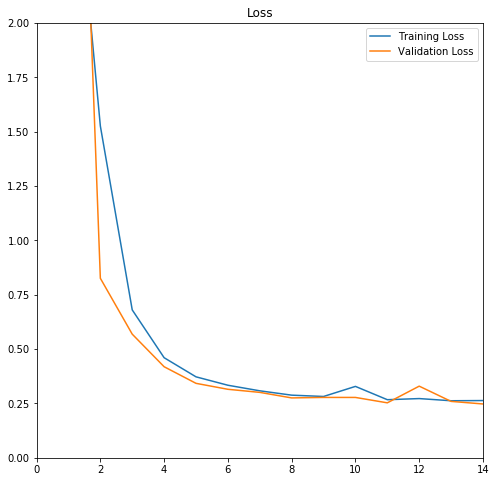

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

n_steps = 15
epochs_range = range(n_steps) # fonction pour récupérer le nbre d'epochs ?
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(0,n_steps-1)
plt.ylim(0,2)
plt.title('Loss')
plt.show()



### Prédiction et analyse des bounding boxes "Gravel" sur quelques images.

A partir de notre modèle, nous allons prédire les bounding boxes sur notre jeu de test (utilisé pour la validation dans l'entraînement). 

In [60]:
K.clear_session()
with open("model3_reg_Gravel.json", 'r') as json_file:
    json_savedModel= json_file.read()
# #load the model architecture 
    model_gravel = tf.keras.models.model_from_json(json_savedModel)
    model_gravel.load_weights('model3_reg_Gravel.h5')
#model2.summary())

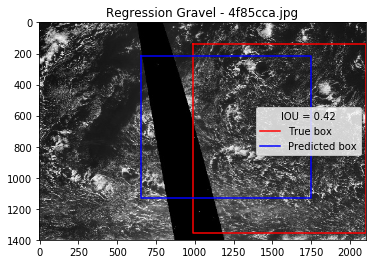

In [61]:
show_prediction(df_gravel_train,model_gravel, 2)

In [62]:

df_gravel['pred'] = df_gravel['path'].apply(lambda x: get_prediction(x,model_gravel))

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [63]:
df_gravel['X_p'] = df_gravel['pred'].apply(lambda x: x[0])
df_gravel['Y_p'] = df_gravel['pred'].apply(lambda x: x[1])
df_gravel['w_p'] = df_gravel['pred'].apply(lambda x: x[2])
df_gravel['h_p'] = df_gravel['pred'].apply(lambda x: x[3])
df_gravel['h_p'] = np.abs(df_gravel['h_p'])
df_gravel['w_p'] = np.abs(df_gravel['w_p'])
df_gravel.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,ImageId,Label,X,Y,w,h,path,pred,X_p,Y_p,w_p,h_p
9,0035239.jpg,Gravel,0.203333,0.850000,0.362857,0.271429,train_images_500/0035239.jpg,"(0.4854915, 0.5693206, 0.52668226, 0.6027401)",0.485492,0.569321,0.526682,0.602740
11,003994e.jpg,Gravel,0.354762,0.517857,0.469524,0.297143,train_images_500/003994e.jpg,"(0.48684782, 0.5915256, 0.3191893, 0.52524495)",0.486848,0.591526,0.319189,0.525245
13,00498ec.jpg,Gravel,0.169762,0.354286,0.117619,0.394286,train_images_500/00498ec.jpg,"(0.7285813, 0.5601388, 0.40586752, 0.61986613)",0.728581,0.560139,0.405868,0.619866
22,0091591.jpg,Gravel,0.344048,0.316071,0.679524,0.605000,train_images_500/0091591.jpg,"(0.42785716, 0.4005361, 0.48744845, 0.474978)",0.427857,0.400536,0.487448,0.474978
26,009e2f3.jpg,Gravel,0.876190,0.624286,0.217143,0.731429,train_images_500/009e2f3.jpg,"(0.3926103, 0.60604686, 0.45713708, 0.5070101)",0.392610,0.606047,0.457137,0.507010


In [64]:
df_gravel = df_gravel.drop(['pred'],axis = 1)
df_gravel.head()

,ImageId,Label,X,Y,w,h,path,X_p,Y_p,w_p,h_p
9,0035239.jpg,Gravel,0.203333,0.850000,0.362857,0.271429,train_images_500/0035239.jpg,0.485492,0.569321,0.526682,0.602740
11,003994e.jpg,Gravel,0.354762,0.517857,0.469524,0.297143,train_images_500/003994e.jpg,0.486848,0.591526,0.319189,0.525245
13,00498ec.jpg,Gravel,0.169762,0.354286,0.117619,0.394286,train_images_500/00498ec.jpg,0.728581,0.560139,0.405868,0.619866
22,0091591.jpg,Gravel,0.344048,0.316071,0.679524,0.605000,train_images_500/0091591.jpg,0.427857,0.400536,0.487448,0.474978
26,009e2f3.jpg,Gravel,0.876190,0.624286,0.217143,0.731429,train_images_500/009e2f3.jpg,0.392610,0.606047,0.457137,0.507010


In [65]:
df_gravel.to_csv('bbox_gravelVGG19_MSE.csv')
df_gravel = pd.read_csv('bbox_gravelVGG19_MSE.csv')

/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


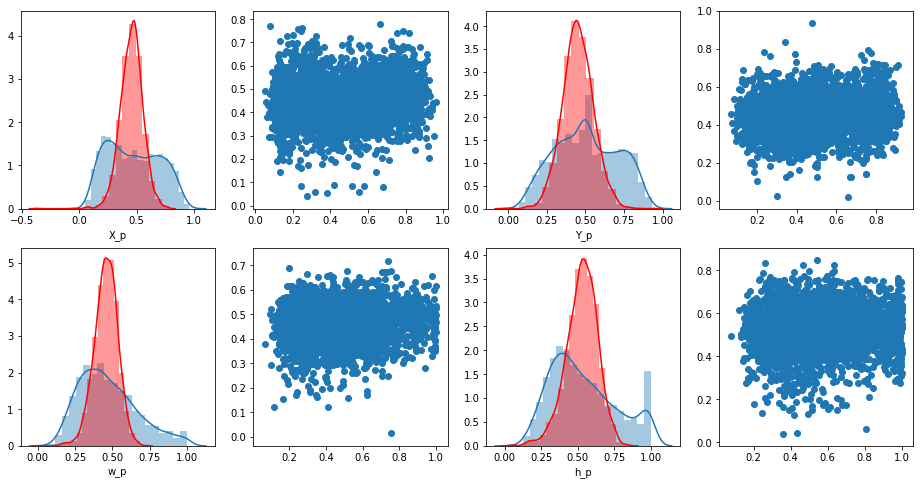

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

true = ['X','Y','w','h']
pred = ['X_p','Y_p','w_p','h_p']

plt.figure(figsize = (16,8))
for i in np.arange(0,8,2) :
    plt.subplot(2,4,i+1)
    sns.distplot(df_gravel[true[(i+1)//2]], bins = 20)
    sns.distplot(df_gravel[pred[(i+1)//2]], bins = 20, color = 'r')
    plt.subplot(2,4,i+2)
    plt.scatter(df_gravel[true[i//2]],df_gravel[pred[i//2]].map(lambda x : np.abs(x)))
    #     sns.relplot(x=true[i//2], y=pred[i//2], data = df_fish)
plt.show();

In [67]:
IOU(df_gravel[['X','Y','w','h']].values ,df_gravel[['X_p','Y_p','w_p','h_p']].values).numpy()

0.5866242857441021

Nous effaçons les paramètres du modèle appris.

In [49]:
del X_train
del X_test
del Y_train
del Y_test

In [50]:
del model
K.clear_session()